# SPG Anaysis & Voronoi

In "My Drive" of your google drive, create a folder called "SPG_data" folder. Than run the code below for connecting to your google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_directory = '/content/drive/MyDrive/SPG_data'
!pip install xlsxwriter
!pip install aicsimageio
!pip install aicspylibczi
!pip install bresenham
!mkdir -p voronoi_dir
voronoi_dir = '/content/voronoi_dir'

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 21.5 MB/s eta 0:00:00
   ━

After running the code below, it will prompt you to upload your SPG_Template.csv file.

In [ ]:
from google.colab import files
for x in range(1):
  print('Upload file number', x + 1)
  files.upload()
import pandas as pd
import xlsxwriter
from openpyxl import Workbook
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import numpy as np
import os
from aicsimageio import AICSImage
from bresenham import bresenham
import re
import shutil

Upload file number 1


Saving mCherry3RVoronoi.csv to mCherry3RVoronoi.csv


## Image Loading

Within your "SPG_data" folder, upload folder containing the images you want to analyze here. Then in the code below, change the "folder_name" variable to the name of the folder you uploaded in "SPG_data". Spelling and Capitalization matter.

Note: Because the computer recognizes pixel only while your measurements are in microns, you will need to check the micron to pixel scales of your images in FIJI by going to Analyze --> Set Scale. Enter this number in the "micron_to_pixel_scale" variable below.

In [ ]:
images = []
folder_name = 'mCherry3R'
micron_to_pixel_scale = 3.0769
# Function to read and store images from a sub-folder
def read_and_store_images(sub_folder, image_list):
    folder_path = os.path.join(base_directory, sub_folder)
    filenames = os.listdir(folder_path)
    sorted_filenames = sorted(filenames, key=lambda x: int(re.search(r'(\d+)', x).group()))
    #for i in range(1, len(sorted_filenames)):
        #prev_animal = int(sorted_filenames[i-1].split()[1].split('.')[0])
        #curr_animal = int(sorted_filenames[i].split()[1].split('.')[0])
        #if prev_animal != curr_animal:
            #a_animal.append(i * 2)

    for filename in sorted_filenames:
        if filename.endswith('.czi'):
            print(filename)
            file_path = os.path.join(folder_path, filename)
            img = AICSImage(file_path)
            image_data = img.get_image_data("YX")
            #uint8_stacked = im_adjust(image_data, autoscale = 'uint8')
            image_list.append(image_data)

#Change name in parenthesis to the name of the genotype folder stored in google drive
#Spelling and capitalizations matter!
read_and_store_images(folder_name, images)

snap-151.czi
snap-152.czi
snap-153.czi
snap-154.czi
snap-155.czi


## Helper Functions

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, LineString
from scipy.ndimage.morphology import binary_erosion
from sklearn.neighbors import KDTree
from os.path import exists
import matplotlib.patches as patches
import matplotlib.path as mpath
import random
import math
import statistics as stats

def empty_directory(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  #Remove files and links
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

def voronoi_finite_polygons_2d(vor, boundary=None):
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if boundary is None:
        radius = vor.points.ptp().max() * 10
    else:
        radius = np.max(np.linalg.norm(boundary - center, axis=1)) * 10

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def get_polygon_edge(vertices):
    # List to store all the points on the polygon edge
    edge_points = []

    # Iterate through consecutive vertex pairs
    for i in range(len(vertices)):
        # Get the start and end points for each edge
        start = vertices[i]
        end = vertices[(i + 1) % len(vertices)]  # Loop back to first point for last edge

        # Get points between start and end using Bresenham's algorithm
        line_points = list(bresenham(start[0], start[1], end[0], end[1]))
        edge_points.extend(line_points)

    # Return unique edge points
    return list(edge_points)

def find_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def micron_to_pixel(micron):
  pixel = []
  for num in micron:
    if num == 'CELL' or num == 'ANIMAL':
      pixel.append(num)
    else:
      pixel.append(float(num) * micron_to_pixel_scale)
  return pixel

def minInterDist(x, y, n): #returns the minimum internuclear distance from nuclei n
    dists = []
    for i in range(len(x)):
        if i != n:
            x_val = (float(x[n]) - float(x[i]))**2
            y_val = (float(y[n]) - float(y[i]))**2
            dist = math.sqrt(x_val + y_val)
            dists.append(dist)
    return min(dists)

def interDist(x, y):
  min_inter_dists = []
  for i in range(len(x)):
    min_inter_dists.append(minInterDist(x, y, i))
  return stats.mean(min_inter_dists), min_inter_dists

def cov_calculator(area):
    mean = stats.mean(area)
    std = stats.stdev(area)
    return std/mean * 100

def voronoi_generator(img, nuclei_x, nuclei_y, border_x, border_y, animal, cell):
  polygon_area = []

  nuclei_points = [[x, y] for x, y in zip(nuclei_x, nuclei_y)]
  border_points = [np.array([x, y], dtype=np.int32) for x, y in zip(border_x, border_y)]
  nuclei_points = np.array(nuclei_points)

  boundary = Polygon(border_points)
  vor = Voronoi(nuclei_points)
  regions, vertices = voronoi_finite_polygons_2d(vor, border_points)
  if not boundary.is_valid:
      print('boundary not valid')
      plt.figure(figsize=(10, 10))
      plt.imshow(img, cmap='gray')
      plt.plot(border_x, border_y)
      plt.show()
  fig, ax = plt.subplots(figsize=(8, 8))

  boundary_patch = patches.Polygon(np.array(boundary.exterior.coords), closed=True, edgecolor='black', facecolor='none', linewidth=2)
  ax.add_patch(boundary_patch)

  # Plot the clipped Voronoi regions with different colors
  for region in regions:
      polygon = vertices[region]
      poly = Polygon(polygon)
      poly = poly.intersection(boundary)
      if not poly.is_empty:
          poly_area = poly.area / (micron_to_pixel_scale**2)
          polygon_area.append(poly_area)
          # Generate a random color
          color = [random.random(), random.random(), random.random()]
          patch = patches.Polygon(np.array(poly.exterior.coords), edgecolor='blue', facecolor=color, alpha=0.4)
          ax.add_patch(patch)

  polygon_area.append("CELL")
  # Plot the points
  ax.plot(nuclei_points[:, 0], nuclei_points[:, 1], 'ro', markersize=4)

  # Set equal aspect ratio
  ax.set_aspect('equal', adjustable='box')

  # Overlay the Voronoi diagram on the original images
  #grayscale_image = cv2.cvtColor(genotype[i], cv2.COLOR_BGR2GRAY)
  ax.imshow(img, cmap='gray', extent=(0, img.shape[1], 0, img.shape[0]), origin='lower')
  plt.xlim(0, img.shape[1])
  plt.ylim(img.shape[0], 0)

  ax.axis('off')
  plt.tight_layout(pad=0)
  plt.savefig(os.path.join(voronoi_dir, f'Voronoi {int(animal)}.{int(cell)}.jpg'), format='jpg', dpi=300, bbox_inches='tight', pad_inches=0)
  plt.show()
  return polygon_area

def nuclei_to_edge(img, nuclei_x, nuclei_y, border_x, border_y):
  n2e_distance = []
  closest_edges = []
  nuclei_points = [[x, y] for x, y in zip(nuclei_x, nuclei_y)]
  for i in range(len(border_x)):
    border_x[i] = int(border_x[i])
    border_y[i] = int(border_y[i])
  border_vertices = [[x,y] for x, y in zip(border_x, border_y)]
  border_points = get_polygon_edge(border_vertices)
  for nuclei in nuclei_points:
    min_distance = float('inf')
    closest_point = None
    for border in border_points:
      d = find_distance(nuclei, border)
      if d < min_distance:
        min_distance = d
        closest_point = border
    closest_edges.append(closest_point)
    min_distance_micron = min_distance / micron_to_pixel_scale
    n2e_distance.append(min_distance_micron)
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap = 'gray')
  for i in range(len(nuclei_points)):
    plt.scatter(nuclei_points[i][0], nuclei_points[i][1], s=10, c='red')
    plt.scatter(closest_edges[i][0], closest_edges[i][1], s=10, c='red')
    plt.plot([nuclei_points[i][0], closest_edges[i][0]], [nuclei_points[i][1], closest_edges[i][1]], linestyle='-', linewidth=1, color='blue')
    x_contour = [points[0] for points in border_points]
    y_contour = [points[1] for points in border_points]
    plt.plot(x_contour, y_contour, linestyle='-', linewidth=1, color='red')
  plt.axis('off')
  plt.show()

  n2e_distance.append("CELL")
  return n2e_distance

def two_point_voronoi(img, nuclei_x, nuclei_y, border_x, border_y, animal, cell):
    polygon_area = []
    # Convert nuclei and border points to arrays
    nuclei_points = np.array([[nuclei_x[0], nuclei_y[0]], [nuclei_x[1], nuclei_y[1]]])
    border_points = np.array([np.array([x, y], dtype=np.int32) for x, y in zip(border_x, border_y)])
    boundary = Polygon(border_points)

    # Calculate the midpoint and perpendicular bisector
    midpoint = np.mean(nuclei_points, axis=0)
    vector = nuclei_points[1] - nuclei_points[0]
    perpendicular_vector = np.array([-vector[1], vector[0]])

    # Create a line through the midpoint with the perpendicular vector
    line_start = midpoint - 100 * perpendicular_vector #both 100
    line_end = midpoint + 100 * perpendicular_vector

    offset = 2000  # Extend beyond the image dimensions to ensure full coverage
    corner1 = line_start + offset * np.array([-perpendicular_vector[1], perpendicular_vector[0]])
    corner2 = line_start - offset * np.array([-perpendicular_vector[1], perpendicular_vector[0]])
    corner3 = line_end + offset * np.array([-perpendicular_vector[1], perpendicular_vector[0]])
    corner4 = line_end - offset * np.array([-perpendicular_vector[1], perpendicular_vector[0]])

    half1 = Polygon([corner1, corner3, line_start, line_end])
    half2 = Polygon([corner2, corner4, line_start, line_end])

    polygon_list = []
    half1 = boundary.intersection(half1)
    half2 = boundary.difference(half1)
    polygon_list.append(half1)
    polygon_list.append(half2)

    fig, ax = plt.subplots(figsize=(8, 8))
    boundary_patch = patches.Polygon(np.array(boundary.exterior.coords), closed=True, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(boundary_patch)

    for poly in polygon_list:
      if not poly.is_empty:
          poly_area = poly.area / (micron_to_pixel_scale**2)
          polygon_area.append(poly_area)
          # Generate a random color
          color = [random.random(), random.random(), random.random()]
          patch = patches.Polygon(np.array(poly.exterior.coords), edgecolor='blue', facecolor=color, alpha=0.4)
          ax.add_patch(patch)

    # Intersect bisector with boundary
    polygon_area.append("CELL")
    # Plot the points
    ax.plot(nuclei_points[:, 0], nuclei_points[:, 1], 'ro', markersize=4)

    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Overlay the Voronoi diagram on the original images
    #grayscale_image = cv2.cvtColor(genotype[i], cv2.COLOR_BGR2GRAY)
    ax.imshow(img, cmap='gray', extent=(0, img.shape[1], 0, img.shape[0]), origin='lower')
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)

    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(voronoi_dir, f'Voronoi {int(animal)}.{int(cell)}.jpg'), format='jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    return polygon_area

def cell_circularity(border_x, border_y):
  circularity = []
  border_points = np.array([np.array([x, y], dtype=np.int32) for x, y in zip(border_x, border_y)])
  boundary = Polygon(border_points)
  area = boundary.area
  perimeter = boundary.length
  circular = (4 * np.pi * area) / (perimeter ** 2)
  circularity.append(circular)
  circularity.append('CELL')
  return circularity

<ipython-input-4-b04e702f3805>:5: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion


## Displaying each images

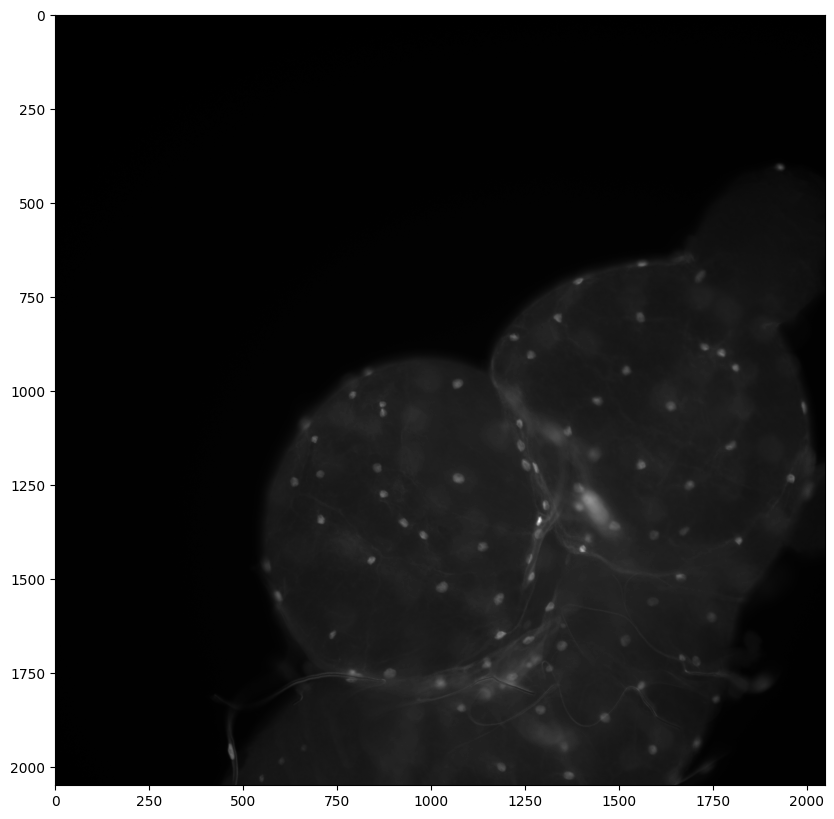

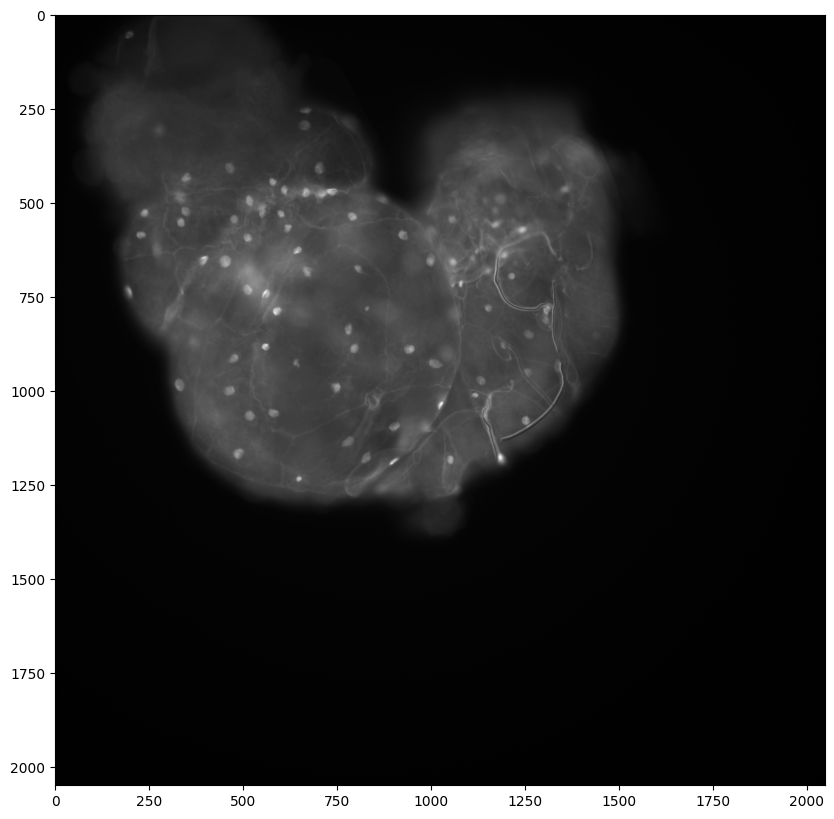

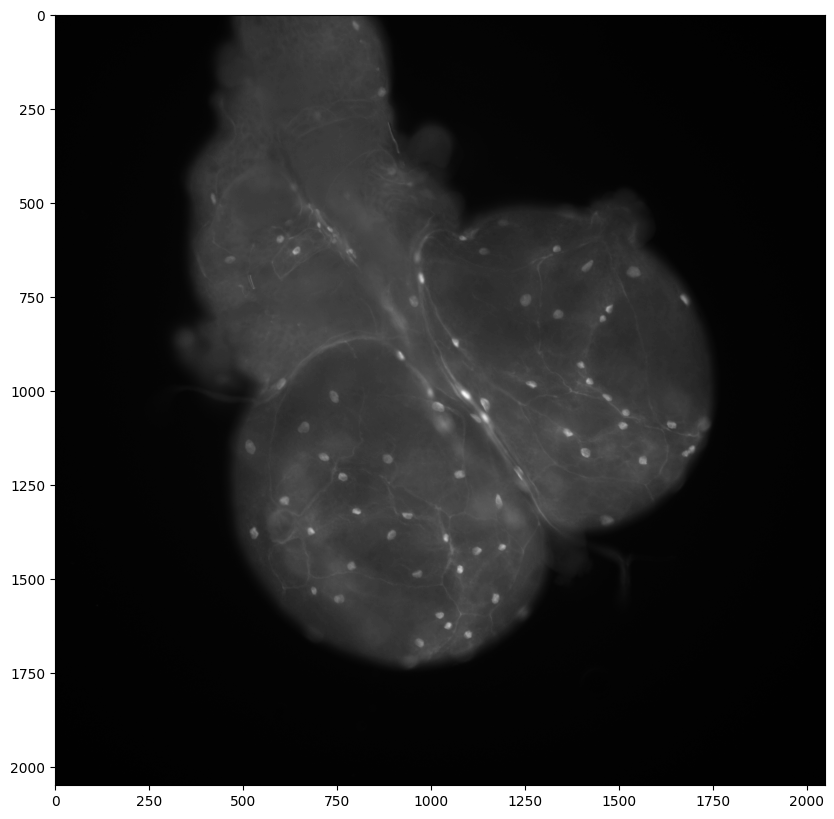

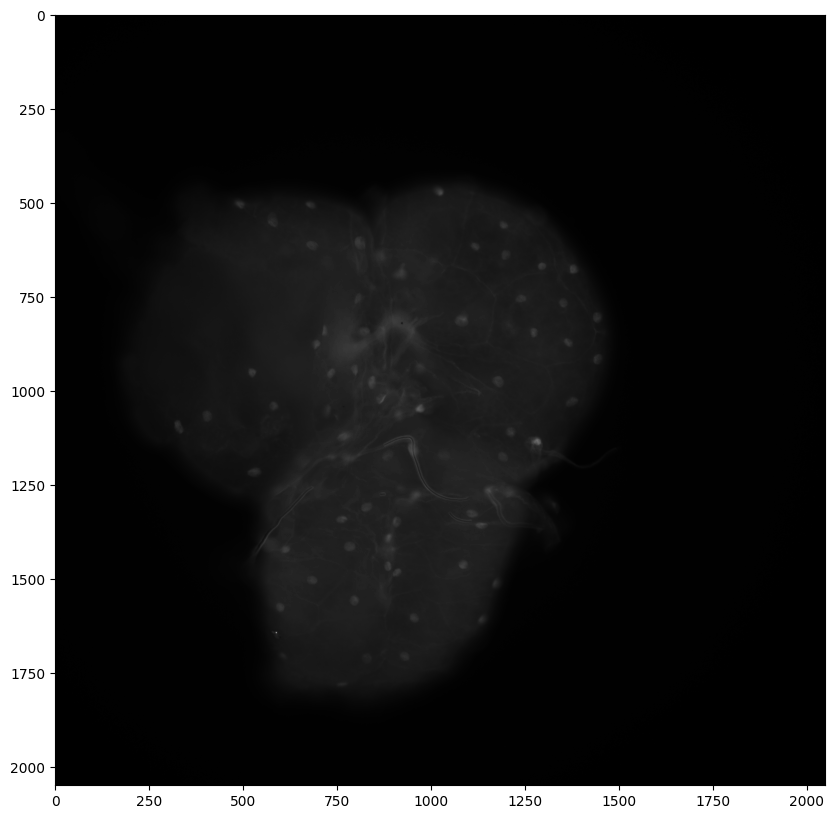

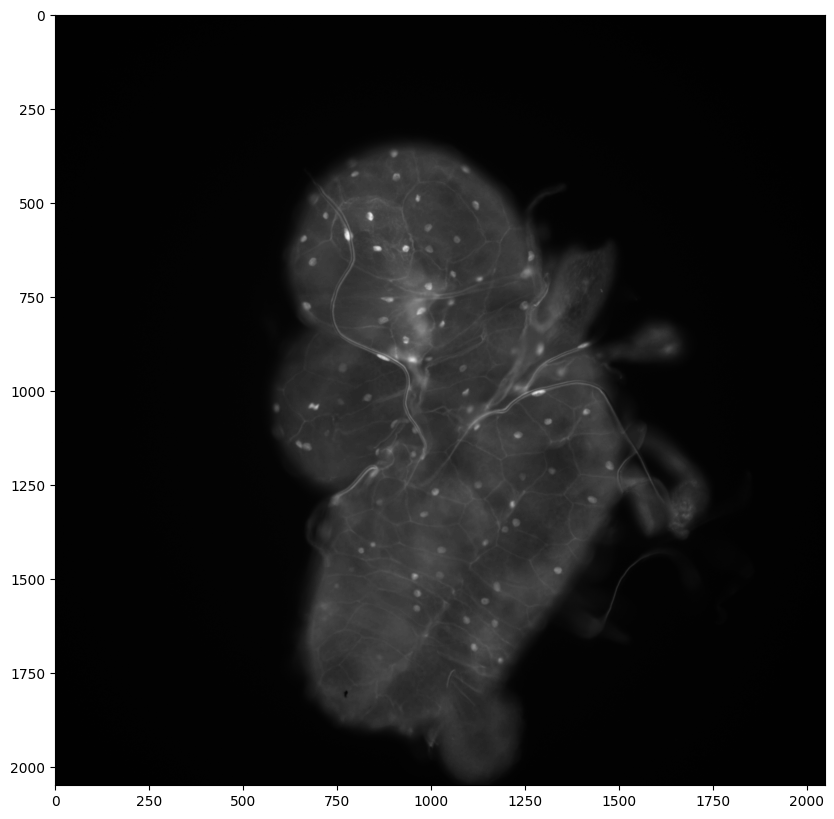

In [ ]:
for img in images:
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap = 'gray')
  #plt.axis('off')
  plt.show()

## Loading SPG_Template.csv

For the dfi variable below, you will need to enter the file path of your uploaded SPG_Template.csv. Simply right click the SPG_Template.csv file located in the Files tab --> copy path.

In [ ]:
dfi = '/content/mCherry3RVoronoi.csv'
wb_name = 'mCherry3R.xlsx'

## Generating Voronoi Polygons & Nuclei to Edge Distances

1.1


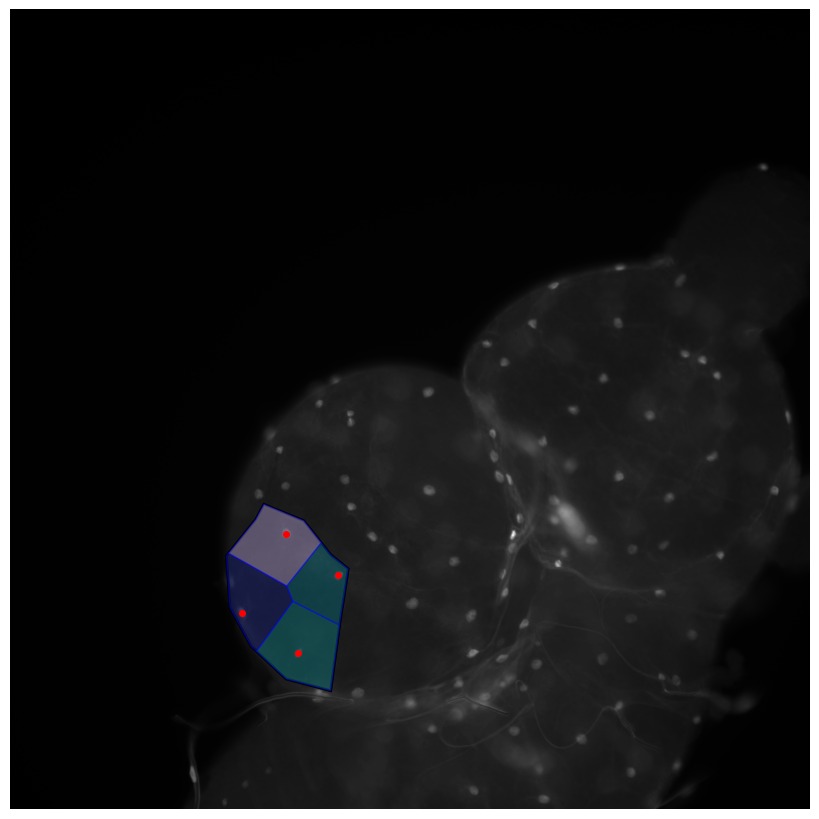

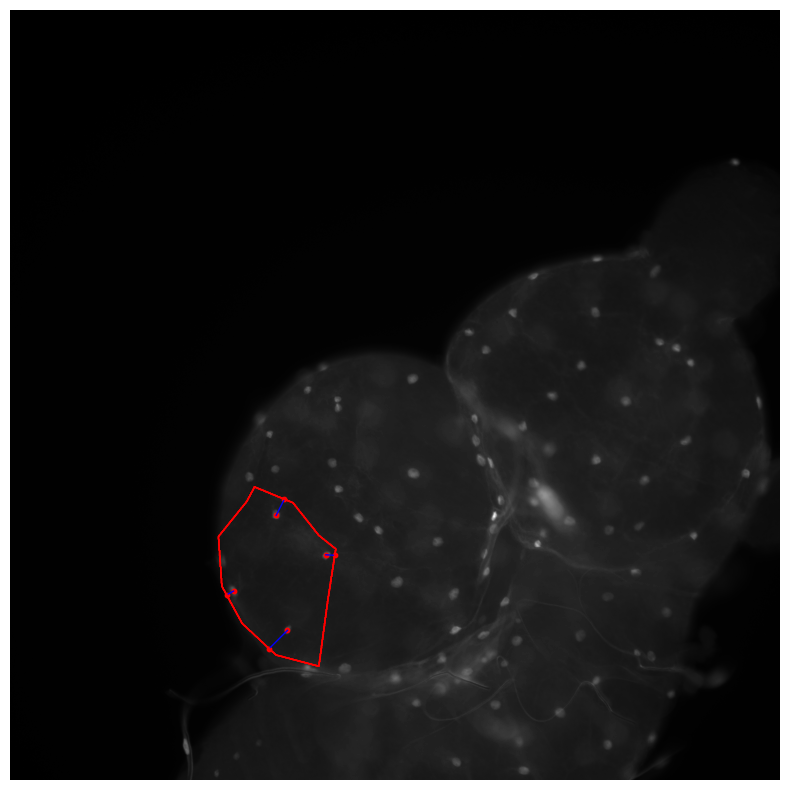

2.1


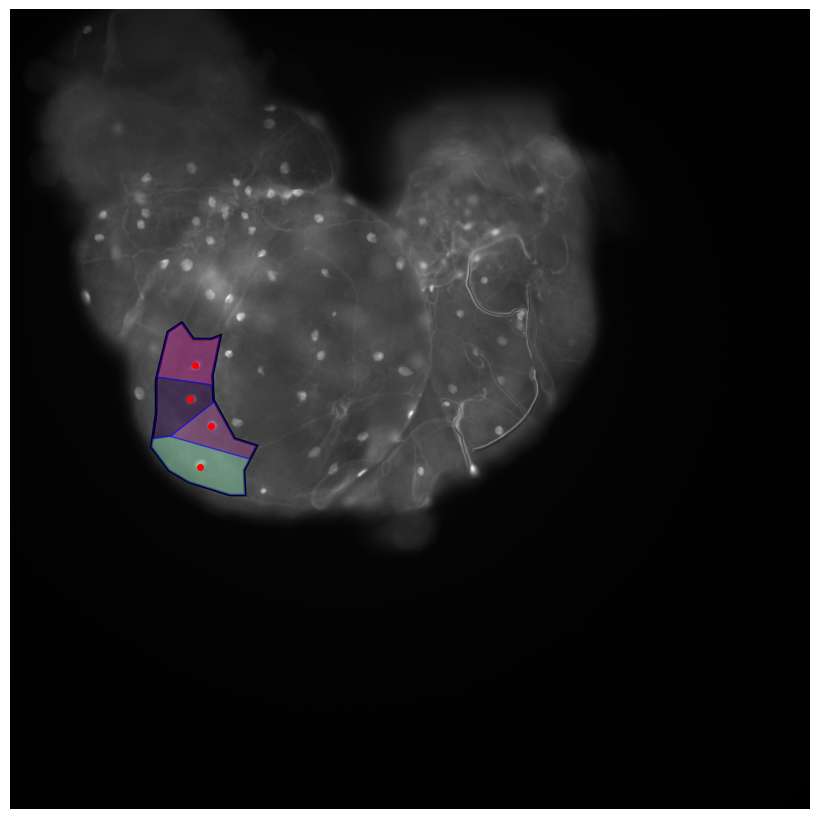

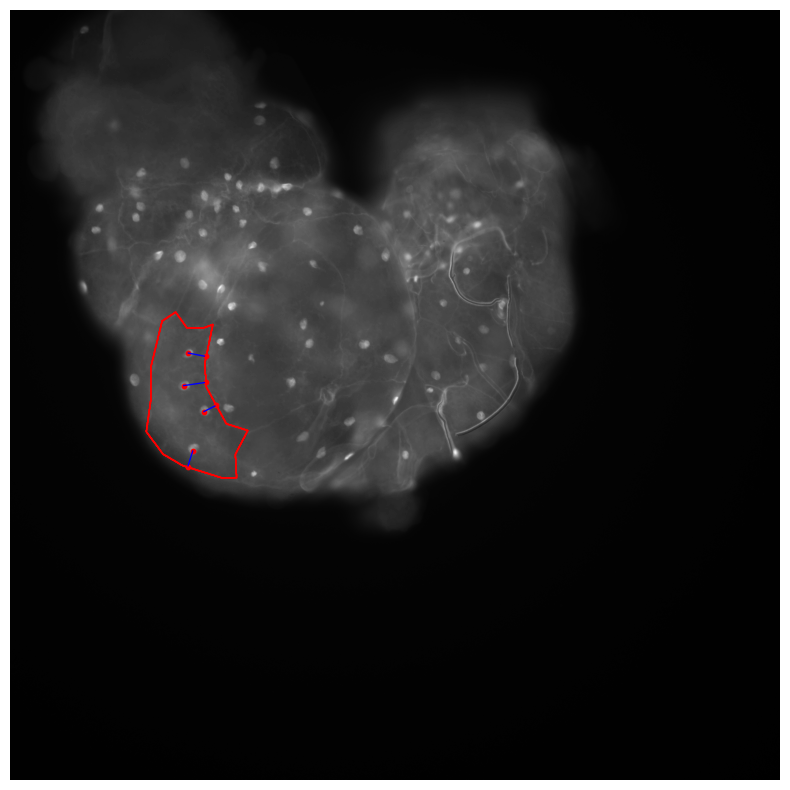

2.2


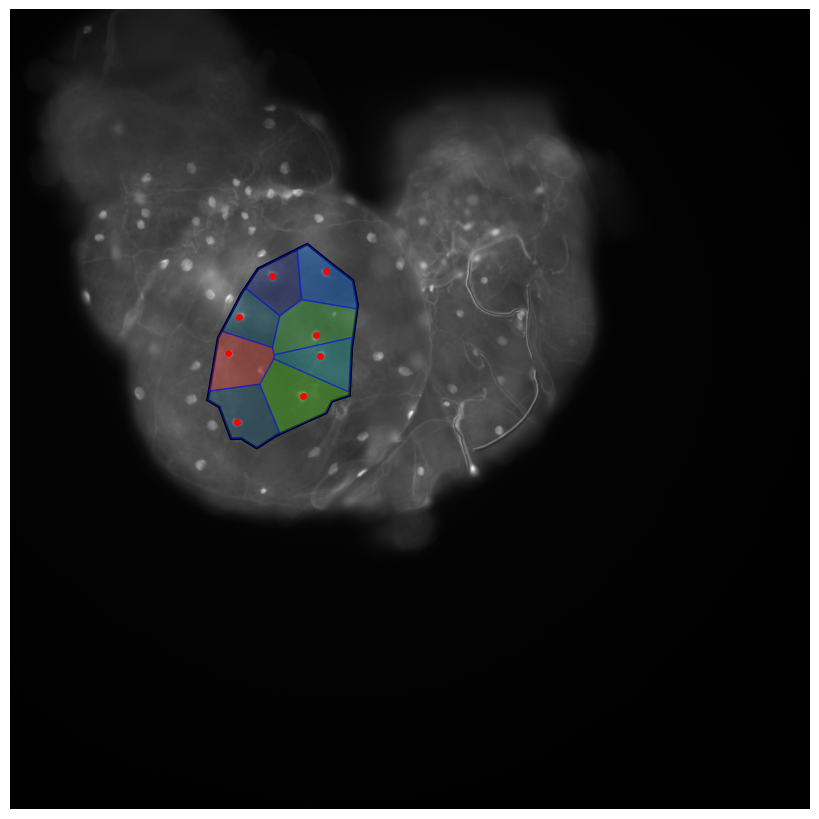

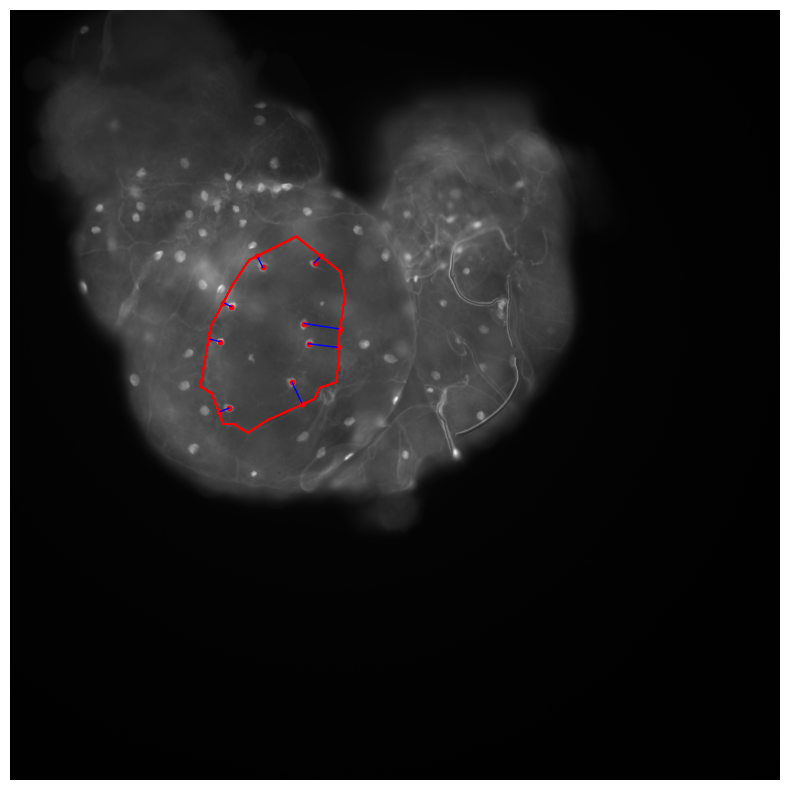

3.1


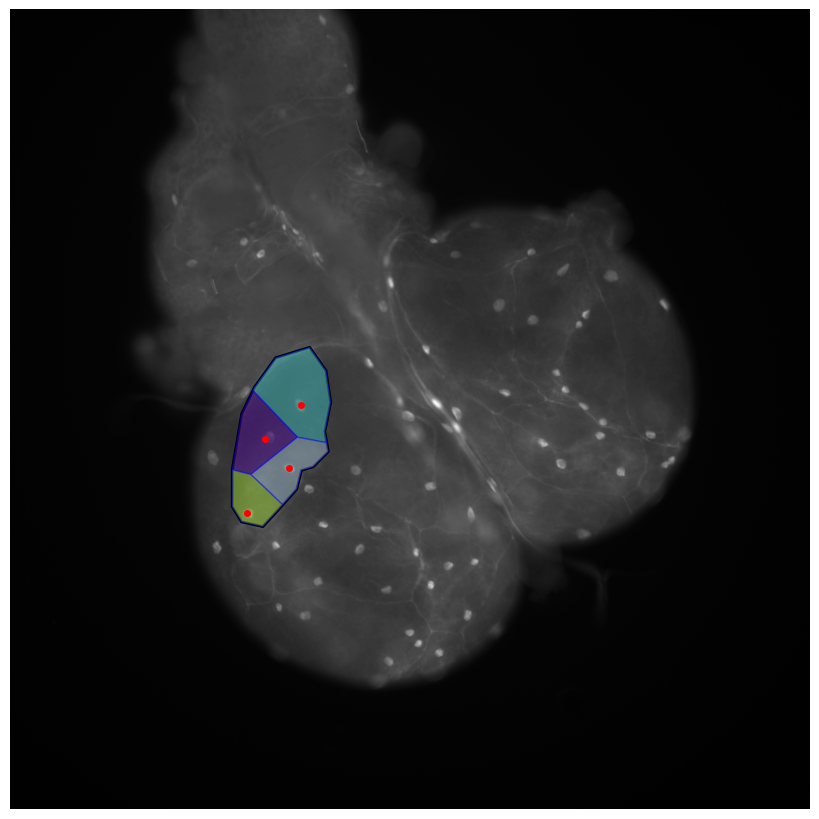

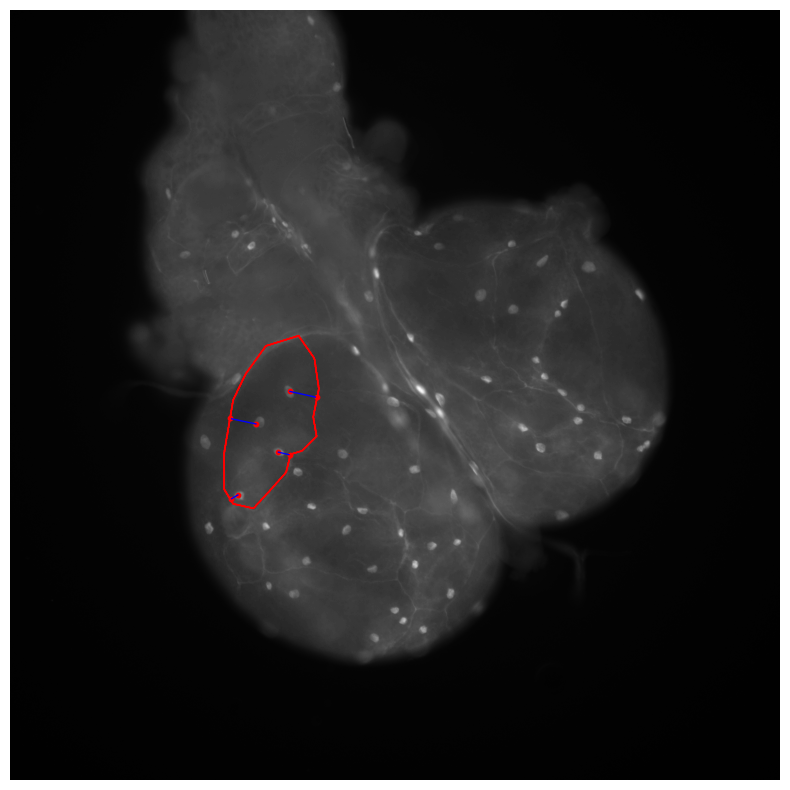

3.2


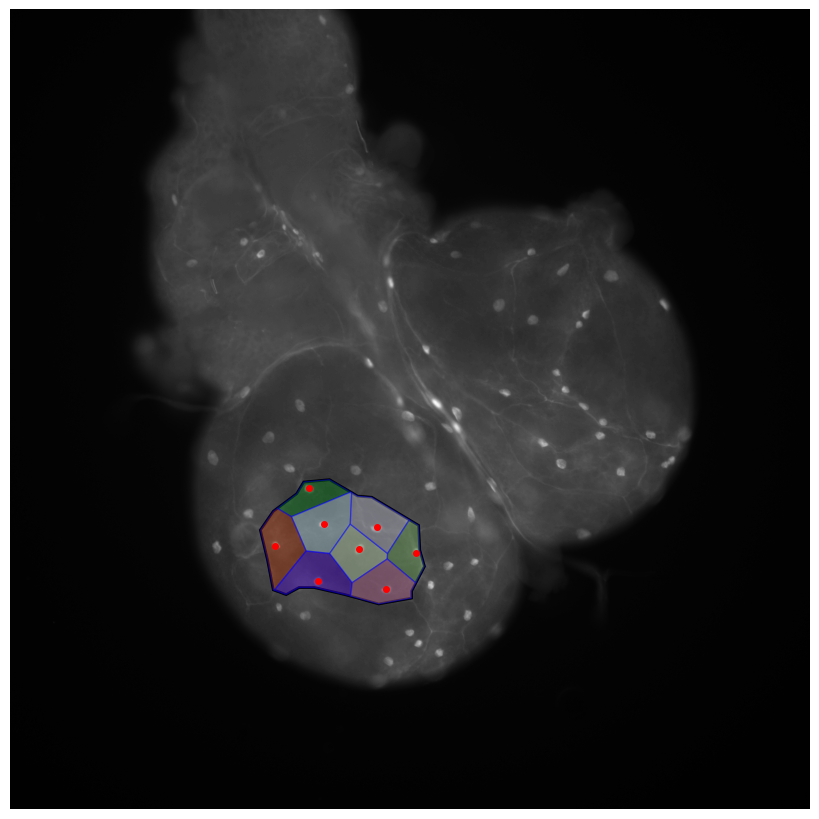

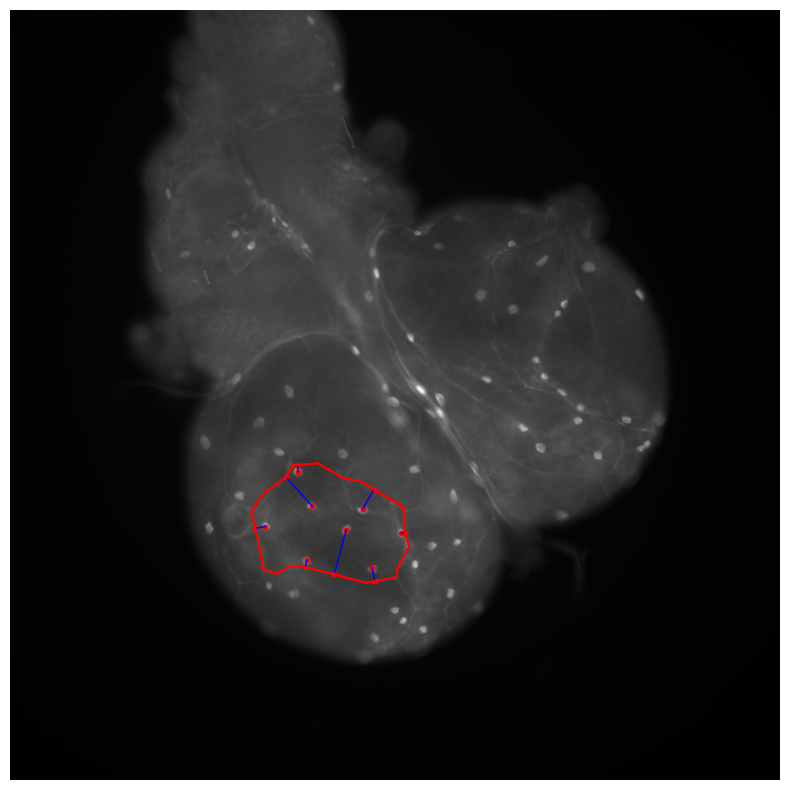

3.3


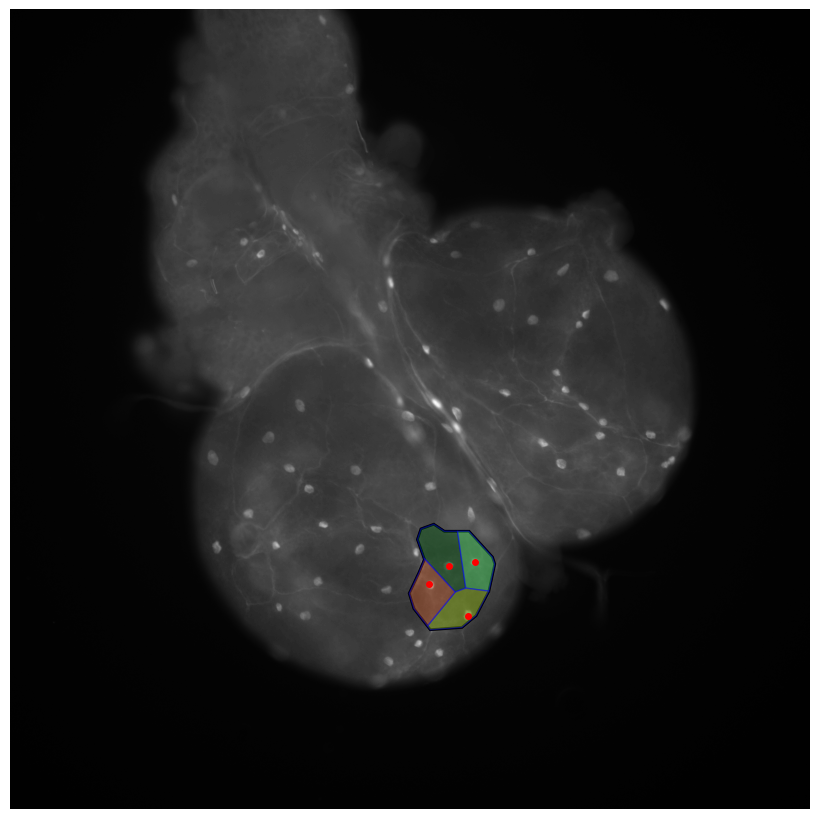

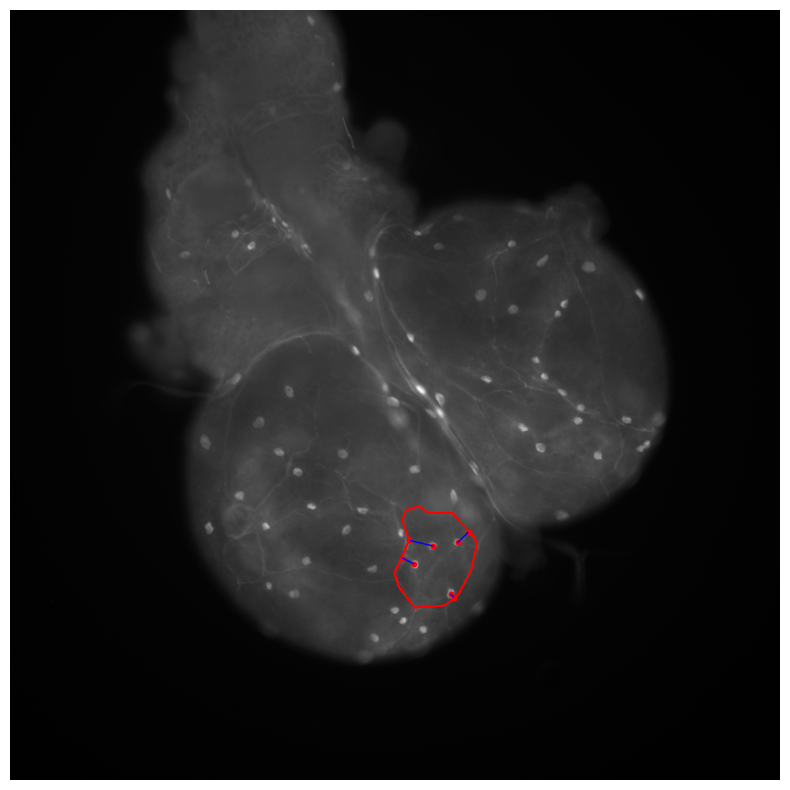

3.4


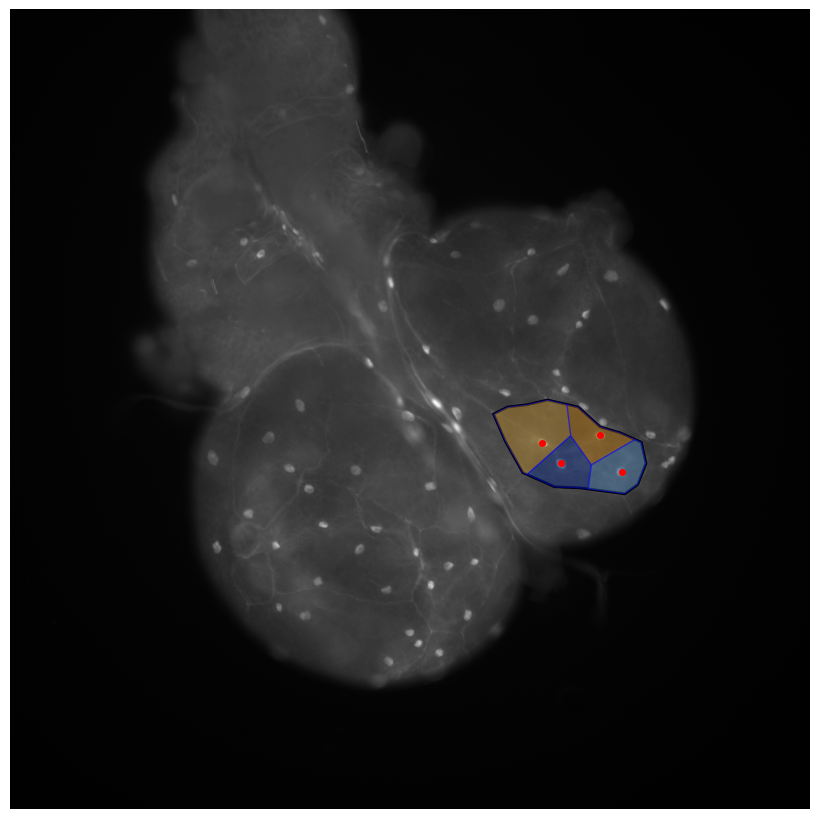

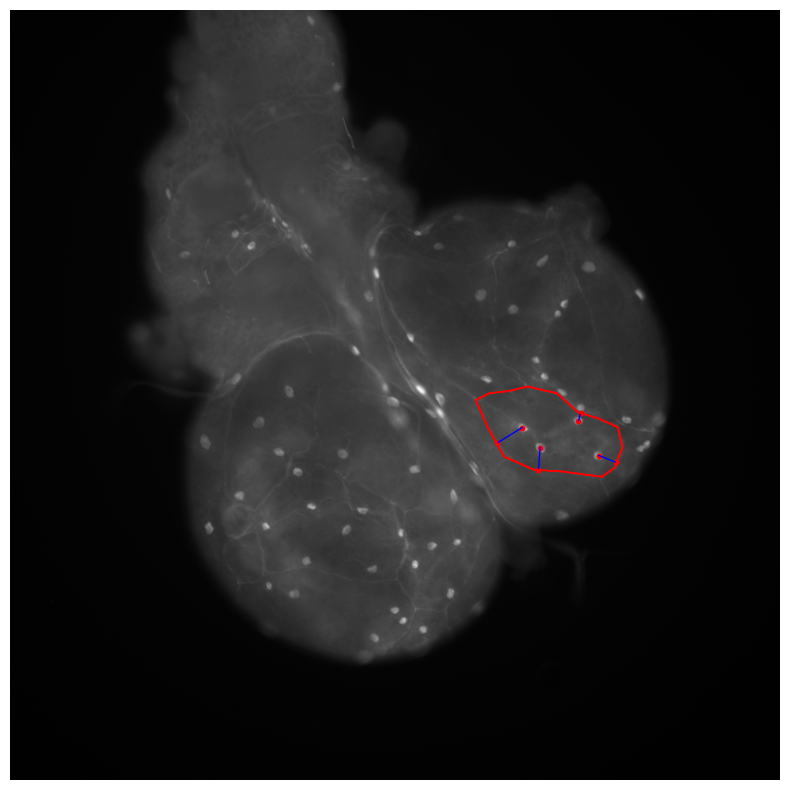

4.1


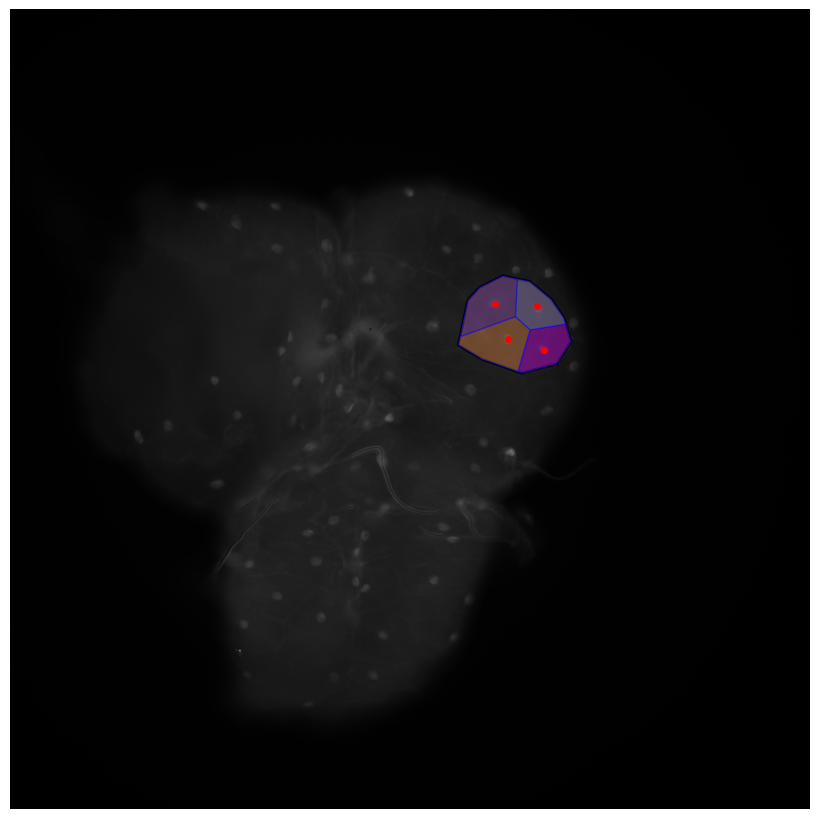

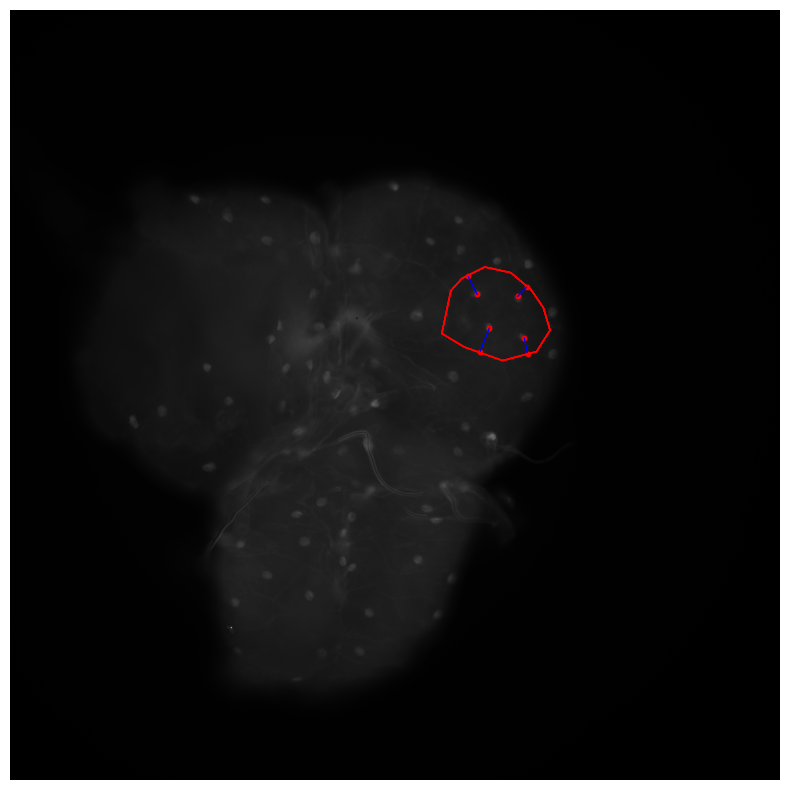

5.1


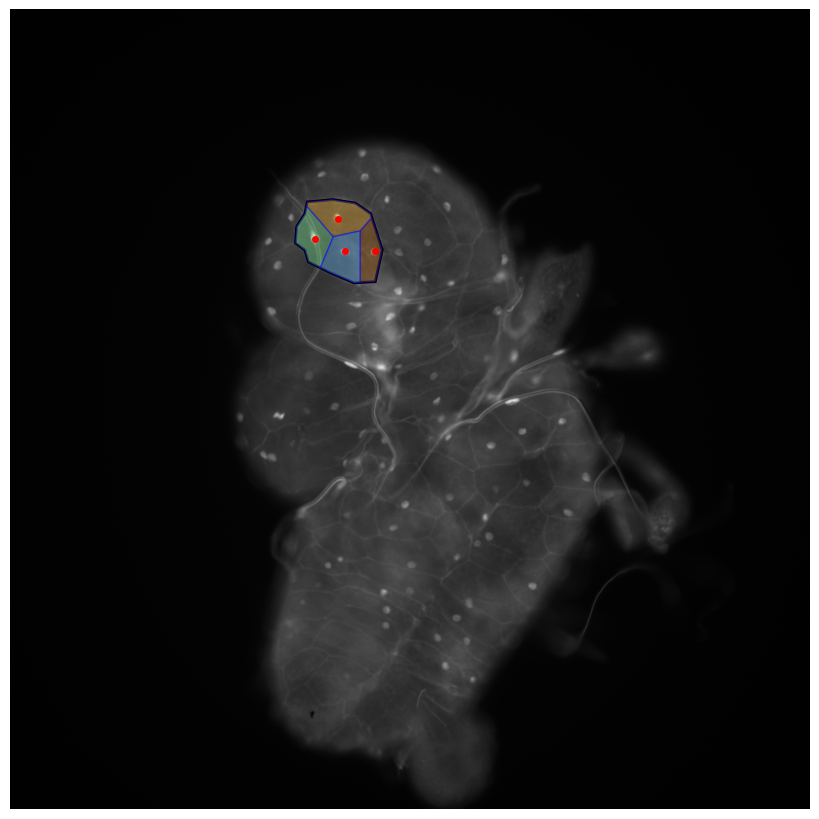

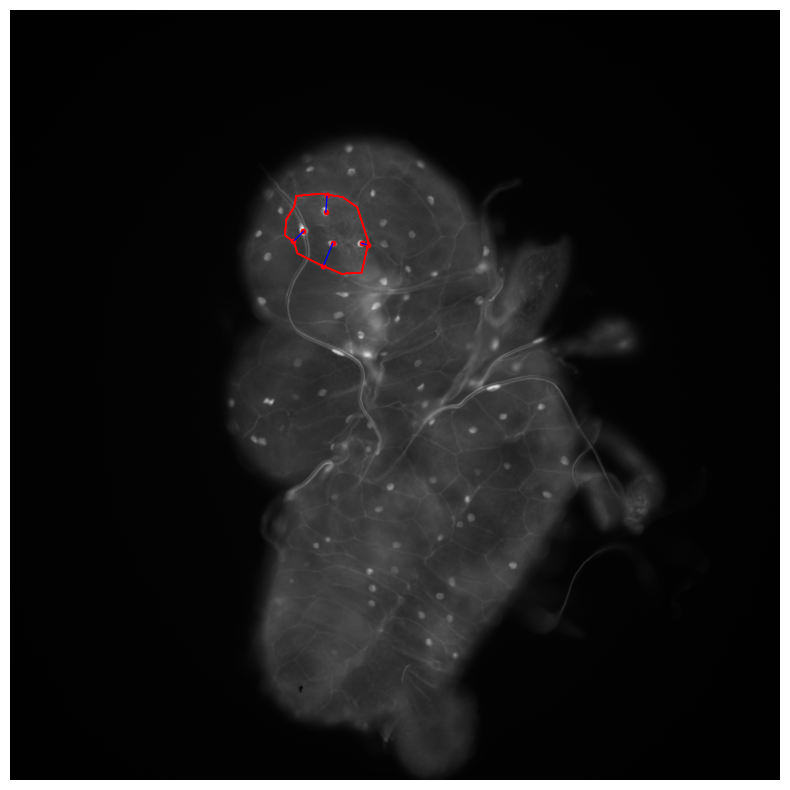

5.2


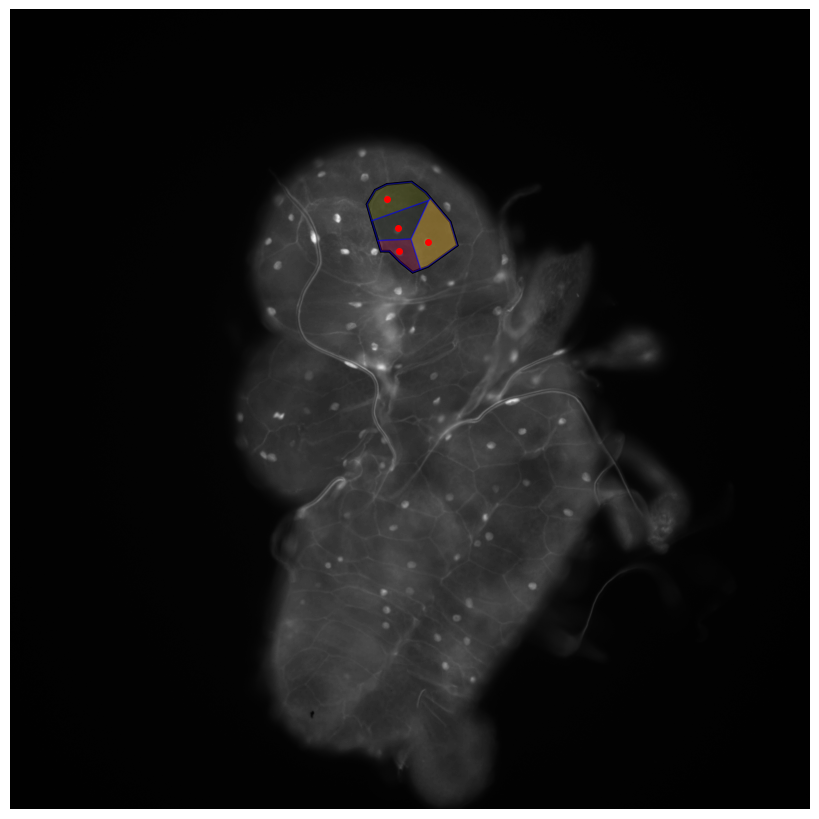

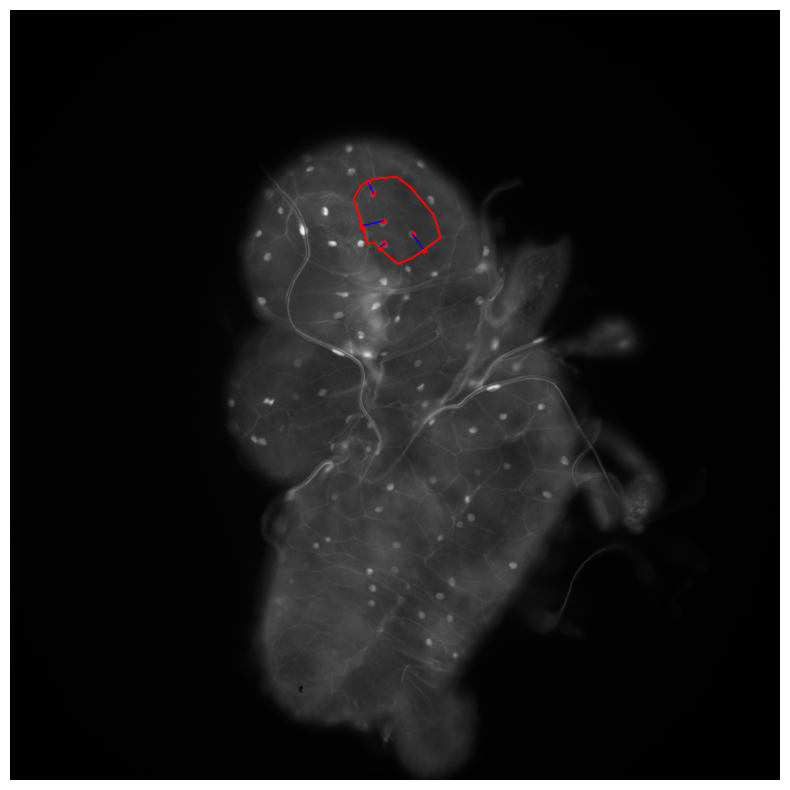

'CELL'

In [ ]:
#Reading in all measurements as lists
df = pd.read_csv(dfi)
nuclei = [x for x in list(df['Nuclei']) if pd.isnull(x) == False]
area = [x for x in list(df['Area']) if pd.isnull(x) == False and (x == 'CELL' or x == 'ANIMAL' or float(x) > 500)]
nuclei_x = [x for x in list(df['Nuclei x']) if pd.isnull(x) == False]
nuclei_y = [x for x in list(df['Nuclei y']) if pd.isnull(x) == False]
boundary_x = [x for x in list(df['Boundary x']) if pd.isnull(x) == False]
boundary_y = [x for x in list(df['Boundary y']) if pd.isnull(x) == False]
voronoi_area = []
nuclei_to_edge_distance = []
circularity = []
#Delete first values for nuclei_x and nuclei_y in each cell (first two values are not coordinates)
i = 0
x_len = len(nuclei_x)
while i < x_len:
  if nuclei_x[i] == 'CELL' or nuclei_x[i] == 'ANIMAL':
    nuclei_x.pop(i+1)
    nuclei_y.pop(i+1)
  x_len = len(nuclei_x)
  i += 1
nuclei_x.pop(0)
nuclei_y.pop(0)

nuclei_x_pixel = micron_to_pixel(nuclei_x)
nuclei_y_pixel = micron_to_pixel(nuclei_y)
boundary_x_pixel = micron_to_pixel(boundary_x)
boundary_y_pixel = micron_to_pixel(boundary_y)

n_cell = []
a_cell = []
a_animal = []
x_animal = []
x_cell = []
b_cell = []

n_cell.append(0)
a_cell.append(0)
a_animal.append(0)
x_animal.append(0)
x_cell.append(0)
b_cell.append(0)

for i in range(len(nuclei)):
        if nuclei[i] == 'ANIMAL' or nuclei[i] == 'CELL':
            n_cell.append(i + 1)

for i in range(len(area)):
    if area[i] == 'ANIMAL' or area[i] == 'CELL':
        a_cell.append(i + 1)

for i in range(len(nuclei_x)):
    if nuclei_x[i] == 'ANIMAL':
        x_animal.append(i + 1)

for i in range(len(area)):
    if area[i] == 'ANIMAL':
        a_animal.append(i + 1)

for i in range(len(boundary_x)):
    if boundary_x[i] == 'CELL' or boundary_x[i] == 'ANIMAL':
        b_cell.append(i + 1)

for i in range(len(nuclei_x)):
    if nuclei_x[i] == 'CELL' or nuclei_x[i] == 'ANIMAL':
        x_cell.append(i + 1)

n_cell.append(len(nuclei) + 1)
a_cell.append(len(area) + 1)
a_animal.append(len(area) + 1)
x_animal.append(len(nuclei_x) + 1)
x_cell.append(len(nuclei_x) + 1)
b_cell.append(len(boundary_x) + 1)

animal_index_1 = []
for num in a_animal:
  animal_index_1.append(int(num/2))


empty_directory(voronoi_dir)

animal_num = 1
for i in range(len(a_cell) - 1):
  if a_cell[i+1] > a_animal[animal_num]:
    animal_num += 1
  which_cell = i - animal_index_1[animal_num - 1] + 1
  print(str(animal_num) + '.' + str(which_cell))
  if len(nuclei_x_pixel[x_cell[i] : x_cell[i+1] - 1]) < 3:
    polygon_areas = two_point_voronoi(images[animal_num-1], nuclei_x_pixel[x_cell[i] : x_cell[i+1] - 1],
                                      nuclei_y_pixel[x_cell[i] : x_cell[i+1] - 1],
                                      boundary_x_pixel[b_cell[i] : b_cell[i+1] - 1],
                                      boundary_y_pixel[b_cell[i] : b_cell[i+1] - 1], animal_num, which_cell)
  else:
    polygon_areas = voronoi_generator(images[animal_num-1], nuclei_x_pixel[x_cell[i] : x_cell[i+1] - 1],
                                      nuclei_y_pixel[x_cell[i] : x_cell[i+1] - 1],
                                      boundary_x_pixel[b_cell[i] : b_cell[i+1] - 1],
                                      boundary_y_pixel[b_cell[i] : b_cell[i+1] - 1], animal_num, which_cell)

  border_points = nuclei_to_edge(images[animal_num-1], nuclei_x_pixel[x_cell[i] : x_cell[i+1] - 1],
                                      nuclei_y_pixel[x_cell[i] : x_cell[i+1] - 1],
                                      boundary_x_pixel[b_cell[i] : b_cell[i+1] - 1],
                                      boundary_y_pixel[b_cell[i] : b_cell[i+1] - 1])
  circular = cell_circularity(boundary_x_pixel[b_cell[i] : b_cell[i+1] - 1], boundary_y_pixel[b_cell[i] : b_cell[i+1] - 1])
  voronoi_area.extend(polygon_areas)
  nuclei_to_edge_distance.extend(border_points)
  circularity.extend(circular)
voronoi_area.pop()
nuclei_to_edge_distance.pop()
circularity.pop()


## Download all Voronoi Polygon Diagrams as zip file

In [ ]:
shutil.make_archive('/content/voronoi_diagrams', 'zip', voronoi_dir)
files.download('/content/voronoi_diagrams.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Output Data to SPG Analysis Data.xlsx

In [ ]:
file_exists = exists(wb_name)
if not file_exists:
  wb = Workbook()
else:
  wb = load_workbook(wb_name)

try:
    ws = wb['Sheet']
    ws.title = 'Summary'
except:
    ws = wb.create_sheet('Summary')

ws['B1'] = 'Nuclei Number'
ws['C1'] = 'Area (micron^2)'
ws['D1'] = 'Internuclear Distances (micron)'
ws['E1'] = 'Nuclei to Edge Distances (micron)'
ws['F1'] = 'Voronoi Area (micron^2)'
ws['G1'] = 'Voronoi COV'
ws['H1'] = 'Cell Circularity'
ws['J1'] = 'Cell Averages'
ws['K1'] = 'Cell'
ws['L1'] = 'Nuclei Number'
ws['M1'] = 'Area (micron^2)'
ws['N1'] = 'Mean Internuclear Distance (micron)'
ws['O1'] = 'Mean Nuclei to Edge Distance (micron)'
ws['P1'] = 'Mean Voronoi Area (micron^2)'
ws['Q1'] = 'Voronoi COV'
ws['R1'] = 'Cell Circularity'

c_row = 2
ave_row = 2

animal_index = []
for num in a_animal:
  animal_index.append(int(num/2))

animal = 1
for i in range(len(a_cell) - 1):
  this_area = float(area[a_cell[i]])
  this_circularity = circularity[a_cell[i]]
  if a_cell[i+1] > a_animal[animal]:
    animal += 1
  which_cell = i - animal_index[animal - 1] + 1

  cell_nuclei = nuclei[n_cell[i] : n_cell[i+1] - 1]
  nuclei_num = int(cell_nuclei[-2])

  mean_inter_dists, inter_dists = interDist(nuclei_x[x_cell[i] : x_cell[i+1] - 1], nuclei_y[x_cell[i] : x_cell[i+1] - 1])

  distance_to_edge = nuclei_to_edge_distance[x_cell[i] : x_cell[i+1] - 1]

  voronoi_polygon_area = voronoi_area[x_cell[i] : x_cell[i+1] - 1]
  voronoi_cov = cov_calculator(voronoi_polygon_area)

  ws['A' + str(c_row)] = 'SPG ' + str(animal) + '.' + str(which_cell)
  ws['B' + str(c_row)] = nuclei_num
  ws['C' + str(c_row)] = this_area
  for j in range(len(inter_dists)):
    ws['D' + str(c_row + j)] = inter_dists[j]
  for k in range(len(distance_to_edge)):
    ws['E' + str(c_row + k)] = distance_to_edge[k]
  for l in range(len(voronoi_polygon_area)):
    ws['F' + str(c_row + l)] = voronoi_polygon_area[l]
  ws['G' + str(c_row)] = voronoi_cov
  ws['H' + str(c_row)] = this_circularity
  c_row += len(inter_dists) + 2

  ws['K' + str(ave_row)] = 'SPG ' + str(animal) + '.' + str(which_cell)
  ws['L' + str(ave_row)] = nuclei_num
  ws['M' + str(ave_row)] = this_area
  ws['N' + str(ave_row)] = mean_inter_dists
  ws['O' + str(ave_row)] = stats.mean(distance_to_edge)
  ws['P' + str(ave_row)] = stats.mean(voronoi_polygon_area)
  ws['Q' + str(ave_row)] = voronoi_cov
  ws['R' + str(ave_row)] = this_circularity

  ave_row += 1

wb.save(wb_name)
